In [1]:
import pandas as pd
import random
import ast
import numpy as np
import scipy.stats as stats 
import statsmodels.stats.api as sms
import seaborn as sns
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import os, glob
import pickle
import itertools
import concurrent.futures
from statsmodels.stats.multitest import multipletests
from sklearn.decomposition import PCA
import statsmodels.api as sm
from stargazer.stargazer import Stargazer, LineLocation
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.linear_model import Lasso, LassoCV
from sklearn.neural_network import MLPRegressor
import xgboost as xgb
from sklearn.neighbors import NearestNeighbors
from adjustText import adjust_text
from sklearn.preprocessing import StandardScaler

from tqdm import tqdm
from copy import deepcopy
from ax import optimize
from ax.plot.contour import plot_contour
from ax.utils.notebook.plotting import init_notebook_plotting, render
from ax.plot.trace import optimization_trace_single_method


from concurrent_functions import get_q2_concurrent, calculate_q2_for_combination
plt.rcParams["font.family"] = "Times New Roman"

import torch
mps_device = torch.device("mps")

# What if we looked at every observation, rather than grouping by instance characteristics?

In [2]:
# change current working directory to the base
os.chdir('../')
os.getcwd()

'/Users/xehu/Desktop/Team Process Mapping/tpm-horse-race-modeling'

In [3]:
# full multi-task data
full_multi_task_data = pd.read_csv('./task_map_explorations_with_multitask/wave_1_raw_score_data.csv').rename(columns={"task": "task_name"}).drop('Unnamed: 0', axis = 1)

In [4]:
# set the score to the best score across repeated attempts, in cases where it saved multiple times
full_multi_task_data = full_multi_task_data.groupby('stageId').apply(lambda x: x.loc[x['score'].idxmax()]).reset_index(drop=True)

In [5]:
full_multi_task_data.head()

,unit,playerCount,task_name,complexity,default_duration,stageId,data.playerIds,score,duration,efficiency
0,4,6,Writing Story,Medium,5,22bJZWfgB3gfKXY6A,"4gSpwy2zhj5TqoZH6,HxHGyhNNY2hLwBQq8,NGyb7W89HC...",100.000000,5.015650,19.937595
1,1,3,Writing Story,Low,5,22wFrSqgf8ESM8pNY,"8KkPHg2uioctf3Rbs,F7RyzbL5Nk2aXrXpA,KwAN4ic6PA...",100.000000,5.149817,19.418167
2,2,1,Divergent Association,Medium,3,24uBQrHu4jKFgGQ24,SWY4y537pm3vP9BCF,83.248037,0.916667,90.816040
3,2,3,Moral Reasoning,High,5,26RnwcdY842ZGSQtT,"A9GsS4XvyujhjaRw5,GncukxCZHcNhuWePC,SZmiBQDByx...",50.000000,0.583333,85.714286
4,1,1,Room Assignment,High,5,28b6Y5xQDcrdFZK2h,ddRBmvwoeaG9kgdyn,88.659794,4.100000,21.624340


In [6]:
# task map
task_map = pd.read_csv('./features/task-mapping/task_map.csv')
task_map = task_map.rename(columns = {"task": "task_name"})

In [7]:
task_name_mapping = {
    "Sudoku": "Sudoku",
    "Moral Reasoning": "Moral Reasoning (Disciplinary Action Case)",
    "Wolf Goat Cabbage": "Wolf, goat and cabbage transfer",
    "Guess the Correlation": "Guessing the correlation",
    "Writing Story": "Writing story",
    "Room Assignment": "Room assignment task",
    "Allocating Resources": "Allocating resources to programs",
    "Divergent Association": "Divergent Association Task",
    "Word Construction": "Word construction from a subset of letters",
    "Whac a Mole": "Whac-A-Mole"
}

In [8]:
task_map.columns

Index(['task_name', 'Q1concept_behav', 'Q3type_1_planning',
       'Q4type_2_generate', 'Q6type_5_cc', 'Q7type_7_battle',
       'Q8type_8_performance', 'Q9divisible_unitary', 'Q10maximizing',
       'Q11optimizing', 'Q13outcome_multip', 'Q14sol_scheme_mul',
       'Q15dec_verifiability', 'Q16shared_knowledge', 'Q17within_sys_sol',
       'Q18ans_recog', 'Q19time_solvability', 'Q20type_3_type_4',
       'Q22confl_tradeoffs', 'Q23ss_out_uncert', 'Q24eureka_question',
       'Q2intel_manip_1', 'Q21intellective_judg_1', 'Q5creativity_input_1',
       'Q25_type6_mixed_motive'],
      dtype='object')

In [9]:
task_map = task_map.rename(
    columns = {
        "Q1concept_behav": "Conceptual-Behavioral",
        "Q3type_1_planning": "Type 1 (Planning)",
        "Q4type_2_generate": "Type 2 (Generate)",
        "Q6type_5_cc": "Type 5 (Cognitive Conflict)",
        "Q7type_7_battle": "Type 7 (Battle)",
        "Q8type_8_performance": "Type 8 (Performance)",
        "Q9divisible_unitary": "Divisible-Unitary",
        "Q10maximizing": "Maximizing",
        "Q11optimizing": "Optimizing",
        "Q13outcome_multip": "Outcome Multiplicity",
        "Q14sol_scheme_mul": "Solution Scheme Multiplicity",
        "Q15dec_verifiability": "Decision Verifiability",
        "Q16shared_knowledge": "Shared Knowledge",
        "Q17within_sys_sol": "Within-System Solution",
        "Q18ans_recog": "Answer Recognizability",
        "Q19time_solvability": "Time Solvability",
        "Q20type_3_type_4": "Type 3 and Type 4 (Objective Correctness)",
        "Q22confl_tradeoffs": "Conflicting Tradeoffs",
        "Q23ss_out_uncert": "Solution Scheme Outcome Uncertainty",
        "Q24eureka_question": "Eureka Question",
        "Q2intel_manip_1" : "Intellectual-Manipulative",
        "Q21intellective_judg_1" : "Intellective-Judgmental",
        "Q5creativity_input_1" : "Creativity Input",
        "Q25_type6_mixed_motive" : "Type 6 (Mixed-Motive)"
    }
)

In [10]:
# make the names match
full_multi_task_data.loc[:, "task_name"] = full_multi_task_data["task_name"].replace(task_name_mapping)

In [11]:
# merge in the task features
full_multi_task_data = pd.merge(left = full_multi_task_data, right = task_map, on = "task_name", how = "left")

# create dummies for complexity
complexity_columns = ["High", "Low", "Medium"]
full_multi_task_data = pd.get_dummies(full_multi_task_data, columns = ["complexity"]).rename(columns = {"complexity_High": "High", "complexity_Low": "Low", "complexity_Medium": "Medium"})
full_multi_task_data[complexity_columns] = full_multi_task_data[complexity_columns].astype(int)

In [12]:
# # add in some communication features
# with open("./data_cache/multi_task_stageId_noncumulative_nonstandardized.pkl", "rb") as cleaned_pickle_file:
# 	stage_based_data = pickle.load(cleaned_pickle_file)
	
# comms_features = stage_based_data.data.groupby(GROUPING_COLS)[["gini_coefficient_sum_num_messages", "sum_num_words", "average_positive_bert"]].agg("mean").reset_index()
# overlapping_columns = set(comms_features.columns).intersection(grouped_performance_with_task_cols.columns)
# comms_features = comms_features.drop(list(overlapping_columns), axis = 1)
# grouped_performance_with_task_cols = pd.concat([grouped_performance_with_task_cols,comms_features], axis = 1)

In [13]:
# these are valid predictors
task_cols_to_use = task_map.drop(["task_name", "Type 6 (Mixed-Motive)"], axis = 1).columns

# Add Compositional Features

In [14]:
players_per_stage = pd.read_csv('./task_map_explorations_with_multitask/wave_1_raw_score_data.csv')[["stageId", "data.playerIds"]]

In [15]:
# This is the list of people who played
players_1 = pd.read_csv('./task_map_explorations_with_multitask/players_wave1_epoch1.csv')
players_2 = pd.read_csv('./task_map_explorations_with_multitask/players_wave1_epoch2.csv')

players = pd.concat([players_1, players_2])

In [16]:
player_workerIds = players[["_id", "id"]].dropna().rename(columns = {"_id": "playerId", "id": "WorkerId"})
# parse out the first part of WorkerId
player_workerIds["WorkerId"] = player_workerIds["WorkerId"].str.split(" ").str[0]

In [17]:
# match playerIds to players_per_stage based on whether data.playerIds CONTAINS the playerId
stage_id_to_player_and_worker = pd.DataFrame(columns=["stageId", "playerId", "WorkerId"])

# Use tqdm to create a progress bar for the loop
for player in tqdm(player_workerIds["playerId"], desc="Matching playerIds"):
    stages_played = players_per_stage[players_per_stage["data.playerIds"].str.contains(player)].copy()

    if len(stages_played) > 0:
        # Set "playerId" column to the player's id
        stages_played["playerId"] = player
        # Get workerId of player
        workerId = player_workerIds.loc[player_workerIds["playerId"] == player, "WorkerId"].values[0]
        # Set "WorkerId" column to the player's id
        stages_played["WorkerId"] = workerId
        new_player_rows = stages_played[["stageId", "playerId", "WorkerId"]]
        stage_id_to_player_and_worker = pd.concat([stage_id_to_player_and_worker, new_player_rows], axis=0)

Matching playerIds:   0%|          | 0/1772 [00:00<?, ?it/s]

Matching playerIds: 100%|██████████| 1772/1772 [00:01<00:00, 1269.84it/s]


In [18]:
# heres the information we have about all the workers
# generate a link here: https://github.com/Watts-Lab/panel/blob/main/clean_data/individuals.csv
panel = pd.read_csv('https://raw.githubusercontent.com/Watts-Lab/panel/main/clean_data/individuals.csv?token=GHSAT0AAAAAACNTSY6GHVPW6PBEVSL4CANYZRVKHGQ')

In [19]:
panel_filtered = panel[["WorkerId", "CRT", "RME"]]

In [20]:
individual_workers_by_stageId = pd.merge(left = stage_id_to_player_and_worker, right = panel_filtered, on = "WorkerId", how = "left")
composition_by_stageId = individual_workers_by_stageId[["stageId", "CRT", "RME"]].groupby("stageId").mean().reset_index()


# Filter to only Teams

In [21]:
team_multi_task_data = full_multi_task_data[full_multi_task_data["playerCount"]>1]
individual_multi_task_data = full_multi_task_data[full_multi_task_data["playerCount"]==1]

In [22]:
team_composition_by_stageId = composition_by_stageId[composition_by_stageId['stageId'].isin(team_multi_task_data['stageId'])]

/Users/xehu/anaconda3/envs/tpm_horserace/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



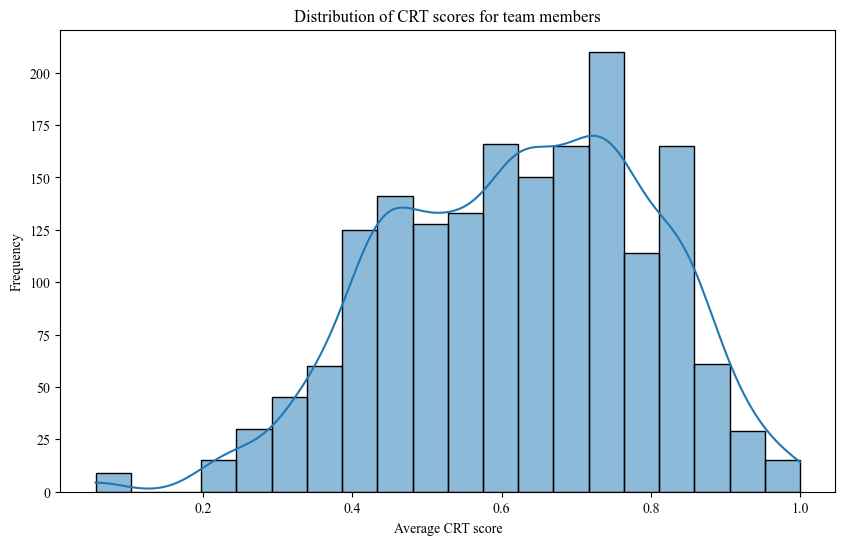

In [23]:
# plot the CRT histogram distribution of team_composition_by_stageId["CRT"]
plt.figure(figsize=(10, 6))
sns.histplot(team_composition_by_stageId["CRT"], bins=20, kde=True)
plt.title("Distribution of CRT scores for team members")
plt.xlabel("Average CRT score")
plt.ylabel("Frequency")
plt.show()

/Users/xehu/anaconda3/envs/tpm_horserace/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



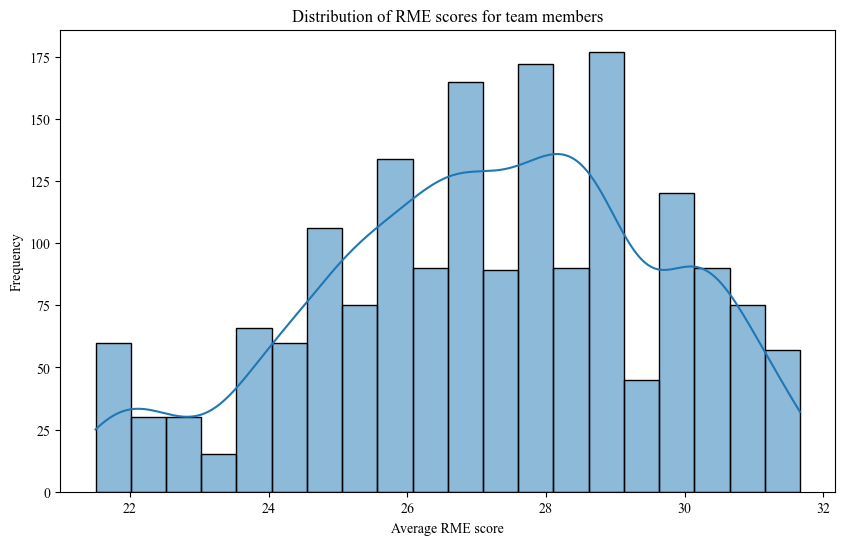

In [24]:
plt.figure(figsize=(10, 6))
sns.histplot(team_composition_by_stageId["RME"], bins=20, kde=True)
plt.title("Distribution of RME scores for team members")
plt.xlabel("Average RME score")
plt.ylabel("Frequency")
plt.show()

In [25]:
# try a simple binary split for CRT and RME
# set CRT_HIGH = 1 if CRT > mean(CRT)
team_composition_by_stageId.loc[:, "CRT_HIGH"] = (team_composition_by_stageId["CRT"] > team_composition_by_stageId["CRT"].mean()).astype(int)
# set RME_HIGH = 1 if RME > mean(RME)
team_composition_by_stageId.loc[:, "RME_HIGH"] = (team_composition_by_stageId["RME"] > team_composition_by_stageId["RME"].mean()).astype(int)

/var/folders/73/jl9lgbkj511fwjxkl9cvw7q00000gq/T/ipykernel_78283/2569426590.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/73/jl9lgbkj511fwjxkl9cvw7q00000gq/T/ipykernel_78283/2569426590.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [26]:
team_composition_by_stageId.head()

,stageId,CRT,RME,CRT_HIGH,RME_HIGH
0,22bJZWfgB3gfKXY6A,0.714286,28.833333,1,1
1,22wFrSqgf8ESM8pNY,0.849206,26.000000,1,0
3,26RnwcdY842ZGSQtT,0.468254,28.000000,0,1
7,2BFbe8Tut5QLrTks9,0.396825,24.333333,0,0
9,2E83K7ZtqnSEYc66t,0.857143,25.333333,1,0


# Exploratory linear regressions

Three outcome variables:
1. **Score**: Normalized such that the highest scoring team gets 100
2. **Duration**: Amount of time spent completing the task (in minutes)
3. **Efficiency**: Score / Duration

In [27]:
# Set coefficients to use
"""
We want:
- Task Features
- Team Size
- CRT and RME Score

Version 1: Let's Intersect them all against each other
"""
for task_col in task_cols_to_use:
    # intersect with team size
    task_col_x_teamsize = team_multi_task_data[task_col]*team_multi_task_data["playerCount"]
    team_multi_task_data.loc[:, task_col + " x playerCount"] = task_col_x_teamsize

    # intersect with CRT
    task_col_x_CRT = team_multi_task_data[task_col]*team_composition_by_stageId["CRT"]
    team_multi_task_data.loc[:, task_col + " x CRT"] = task_col_x_CRT

    # intersect with RME
    task_col_x_RME = team_multi_task_data[task_col]*team_composition_by_stageId["RME"]
    team_multi_task_data.loc[:, task_col + " x RME"] = task_col_x_RME

/var/folders/73/jl9lgbkj511fwjxkl9cvw7q00000gq/T/ipykernel_78283/2959774953.py:13: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/73/jl9lgbkj511fwjxkl9cvw7q00000gq/T/ipykernel_78283/2959774953.py:17: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/73/jl9lgbkj511fwjxkl9cvw7q00000gq/T/ipykernel_78283/2959774953.py:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in th

In [28]:
print("Design Decision -  Drop Rows with NA's. Number of Rows Affected:")
print(len(team_multi_task_data)-len(team_multi_task_data.dropna()))

Design Decision -  Drop Rows with NA's. Number of Rows Affected:
30


In [29]:
team_multi_task_data = team_multi_task_data.dropna()

In [30]:
task_cols_and_derivatives = list(task_cols_to_use) + [col for col in team_multi_task_data.columns if "x" in col]
# get a unique list
task_cols_and_derivatives = list(set(task_cols_and_derivatives))

In [31]:
# Add all composition information to the main data table
team_multi_task_data = pd.merge(team_composition_by_stageId, team_multi_task_data, on = "stageId", how = "inner")

In [32]:
# Design decision --- standardize iv (standardize task features, RME, CRT, and any interaction terms involving task features)
team_multi_task_data = team_multi_task_data.copy()
team_multi_task_data[task_cols_and_derivatives + ["CRT", "RME"]] = StandardScaler().fit_transform(team_multi_task_data[task_cols_and_derivatives + ["CRT", "RME"]])


In [33]:
# Design desicion --- use lasso to determine optimal columns; we'll select this as the subset moving forward since many task cols are "repeated"

In [34]:
def feature_downselect_with_lasso(cols):
    lassocv = LassoCV(cv=10, random_state=0, max_iter=100000).fit(team_multi_task_data[cols], team_multi_task_data["score"])
    best_alpha = lassocv.alpha_
    fitted_lasso_model = Lasso(alpha = best_alpha, max_iter=100000).fit(team_multi_task_data[cols], team_multi_task_data["score"])

    lasso_feature_names = fitted_lasso_model.feature_names_in_
    lasso_coefs = fitted_lasso_model.coef_

    lasso_weights = pd.DataFrame(
        {"features": lasso_feature_names,
        "LASSO_weight": lasso_coefs}
    )

    # filter for LASSO_weight != 0
    return lasso_weights[lasso_weights['LASSO_weight'] != 0]["features"]

nonzero_lasso_weights = feature_downselect_with_lasso(task_cols_and_derivatives + ["CRT", "RME", "playerCount"])

In [35]:
# force in RME, CRTA, and playerCount
nonzero_lasso_weights = list(set(list(nonzero_lasso_weights) + ["RME", "CRT", "playerCount"]))

In [36]:
all_features_and_interactions = task_cols_and_derivatives + ["CRT", "RME", "playerCount"] + ["High", "Medium"]

In [37]:
score_lm = sm.OLS(endog = team_multi_task_data["score"], exog=sm.add_constant(team_multi_task_data[all_features_and_interactions])).fit()

# Remove duration and efficiency
# duration_lm = sm.OLS(endog = full_data_standardized["duration"], exog=sm.add_constant(full_data_standardized[reg_coefficients])).fit()
# efficiency_lm = sm.OLS(endog = full_data_standardized["efficiency"], exog=sm.add_constant(full_data_standardized[reg_coefficients])).fit()

models = [score_lm]#, duration_lm, efficiency_lm]
stargazer = Stargazer(models)

In [38]:
stargazer

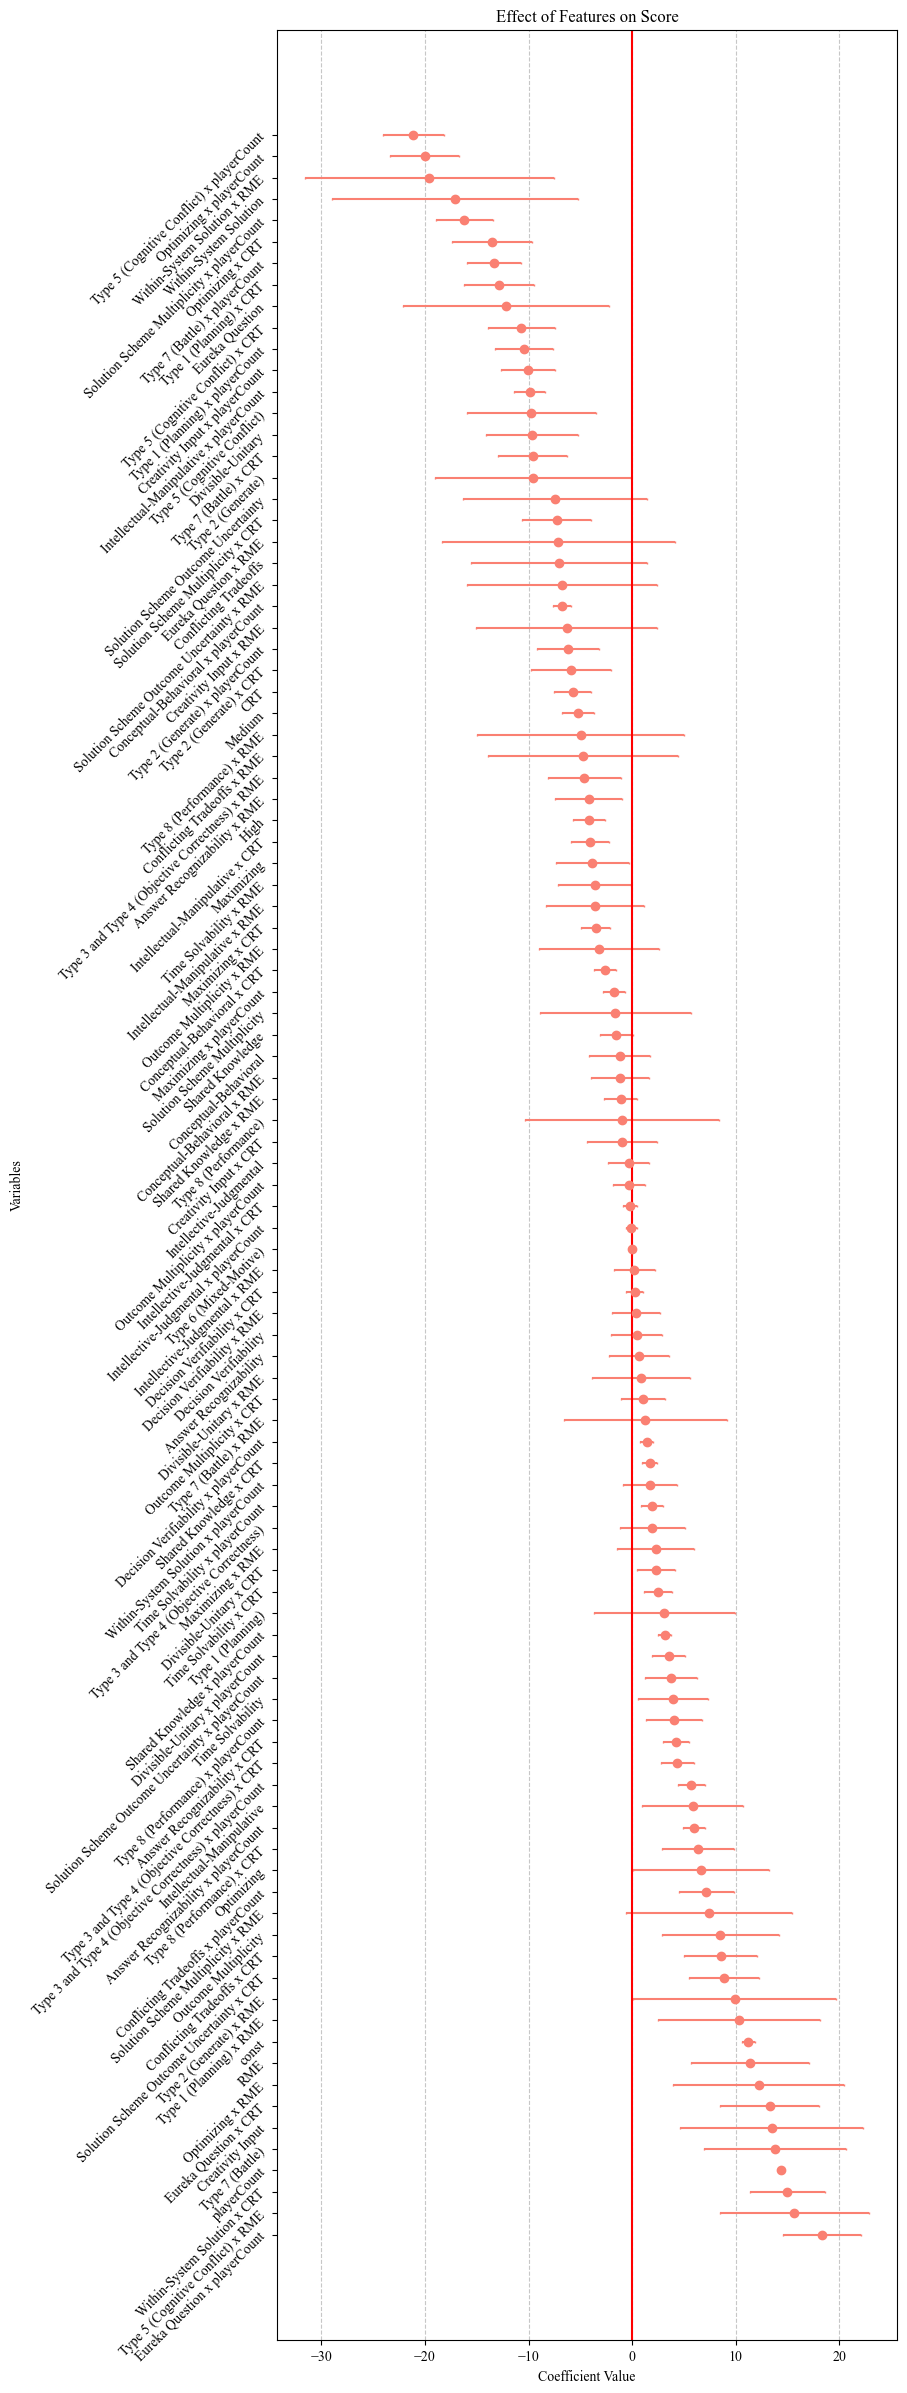

In [39]:
model_names = ["Score"]#, "Duration", "Efficiency"]
colors = ['salmon']#, 'lightblue', 'violet']

# Create a DataFrame to organize the parameters for easier manipulation
params_df = pd.DataFrame([model.params for model in models], index=model_names)
sorted_columns = params_df.sum().sort_values(ascending=False).index
# order everything by smallest to largest effect size
params_df = params_df.reindex(columns=sorted_columns)
stderr_df = pd.DataFrame([model.bse for model in models], index=model_names).reindex(columns=sorted_columns)

fig, ax = plt.subplots(figsize=(8, 30))
y_positions = np.arange(len(params_df.columns)) * 10 # spread out y-positions

for i, model_name in enumerate(model_names):
    means = params_df.loc[model_name]
    errors = stderr_df.loc[model_name]

    plt.errorbar(means, y_positions + i * 0.2, xerr=errors, fmt='o', label=f'{model_name}', color=colors[i], capsize=1)

ax.set_title('Effect of Features on Score')
ax.set_xlabel('Coefficient Value') 
ax.set_ylabel('Variables')  
ax.set_yticks(y_positions + (len(models) - 1) * 0.2 / 2)  
ax.set_yticklabels(params_df.columns, rotation=45, ha="right")  
ax.grid(axis='x', linestyle='--', alpha=0.7)  
# ax.legend()

plt.axvline(x=0, color='r', linestyle='-') 
plt.show()

Now Run Separate Models for Large v. Small Teams; High versus Low CRT; High Verus Low RME

In [40]:
task_cols_to_use

Index(['Conceptual-Behavioral', 'Type 1 (Planning)', 'Type 2 (Generate)',
       'Type 5 (Cognitive Conflict)', 'Type 7 (Battle)',
       'Type 8 (Performance)', 'Divisible-Unitary', 'Maximizing', 'Optimizing',
       'Outcome Multiplicity', 'Solution Scheme Multiplicity',
       'Decision Verifiability', 'Shared Knowledge', 'Within-System Solution',
       'Answer Recognizability', 'Time Solvability',
       'Type 3 and Type 4 (Objective Correctness)', 'Conflicting Tradeoffs',
       'Solution Scheme Outcome Uncertainty', 'Eureka Question',
       'Intellectual-Manipulative', 'Intellective-Judgmental',
       'Creativity Input'],
      dtype='object')

In [41]:
small_team_data = team_multi_task_data[team_multi_task_data["playerCount"] == 3]
large_team_data = team_multi_task_data[team_multi_task_data["playerCount"] == 6]

high_crt_team_data = team_multi_task_data[team_multi_task_data["CRT_HIGH"] == 1]
low_crt_team_data = team_multi_task_data[team_multi_task_data["CRT_HIGH"] == 0]

high_rme_team_data = team_multi_task_data[team_multi_task_data["RME_HIGH"] == 1]
low_rme_team_data = team_multi_task_data[team_multi_task_data["RME_HIGH"] == 0]

In [42]:
# get task_cols_and_derivatives without playerCount
task_cols_and_derivatives_no_playerCount = [col for col in task_cols_and_derivatives if "playerCount" not in col]

# get task_cols_and_derivatives without RME
task_cols_and_derivatives_no_RME = [col for col in task_cols_and_derivatives if "RME" not in col]

# get task_cols_and_derivatives without CRT
task_cols_and_derivatives_no_CRT = [col for col in task_cols_and_derivatives if "CRT" not in col]

In [43]:
small_team_lm = sm.OLS(endog = small_team_data["score"], exog=sm.add_constant(small_team_data[task_cols_and_derivatives_no_playerCount + ["Medium", "High", "CRT", "RME"]])).fit()
large_team_lm = sm.OLS(endog = large_team_data["score"], exog=sm.add_constant(large_team_data[task_cols_and_derivatives_no_playerCount + ["Medium", "High", "CRT", "RME"]])).fit()

highCRT_team_lm = sm.OLS(endog = high_crt_team_data["score"], exog=sm.add_constant(high_crt_team_data[task_cols_and_derivatives_no_CRT + ["Medium", "High", "playerCount", "RME"]])).fit()
lowCRT_team_lm = sm.OLS(endog = low_crt_team_data["score"], exog=sm.add_constant(low_crt_team_data[task_cols_and_derivatives_no_CRT + ["Medium", "High", "playerCount", "RME"]])).fit()

highRME_team_lm = sm.OLS(endog = high_rme_team_data["score"], exog=sm.add_constant(high_rme_team_data[task_cols_and_derivatives_no_RME + ["Medium", "High", "playerCount", "CRT"]])).fit()
lowRME_team_lm = sm.OLS(endog = low_rme_team_data["score"], exog=sm.add_constant(low_rme_team_data[task_cols_and_derivatives_no_RME + ["Medium", "High", "playerCount", "CRT"]])).fit()

In [44]:
models_size = [small_team_lm, large_team_lm]
models_CRT = [highCRT_team_lm, lowCRT_team_lm]
models_RME = [highRME_team_lm, lowRME_team_lm]

In [45]:
stargazer_size = Stargazer(models_size)
stargazer_size

In [46]:
stargazer_crt = Stargazer(models_CRT)
stargazer_crt

In [47]:
stargazer_rme = Stargazer(models_RME)
stargazer_rme

In [48]:
def plot_stargazer_for_two_models(models, model_1_name, model_2_name, title = 'Effect of Features on Score'):
    model_names = [model_1_name, model_2_name]
    colors = ['salmon', 'lightblue']

    # Create a DataFrame to organize the parameters for easier manipulation
    params_df = pd.DataFrame([model.params for model in models], index=model_names)
    sorted_columns = params_df.sum().sort_values(ascending=False).index
    # order everything by smallest to largest effect size
    params_df = params_df.reindex(columns=sorted_columns)
    stderr_df = pd.DataFrame([model.bse for model in models], index=model_names).reindex(columns=sorted_columns)

    fig, ax = plt.subplots(figsize=(8, 30))
    y_positions = np.arange(len(params_df.columns)) * 10 # spread out y-positions

    for i, model_name in enumerate(model_names):
        means = params_df.loc[model_name]
        errors = stderr_df.loc[model_name]

        plt.errorbar(means, y_positions + i * 0.2, xerr=errors, fmt='o', label=f'{model_name}', color=colors[i], capsize=1)

    ax.set_title(title)
    ax.set_xlabel('Coefficient Value') 
    ax.set_ylabel('Variables')  
    ax.set_yticks(y_positions + (len(models) - 1) * 0.2 / 2)  
    ax.set_yticklabels(params_df.columns, rotation=45, ha="right")  
    ax.grid(axis='x', linestyle='--', alpha=0.7)  
    ax.legend()

    plt.axvline(x=0, color='r', linestyle='-') 
    plt.show()

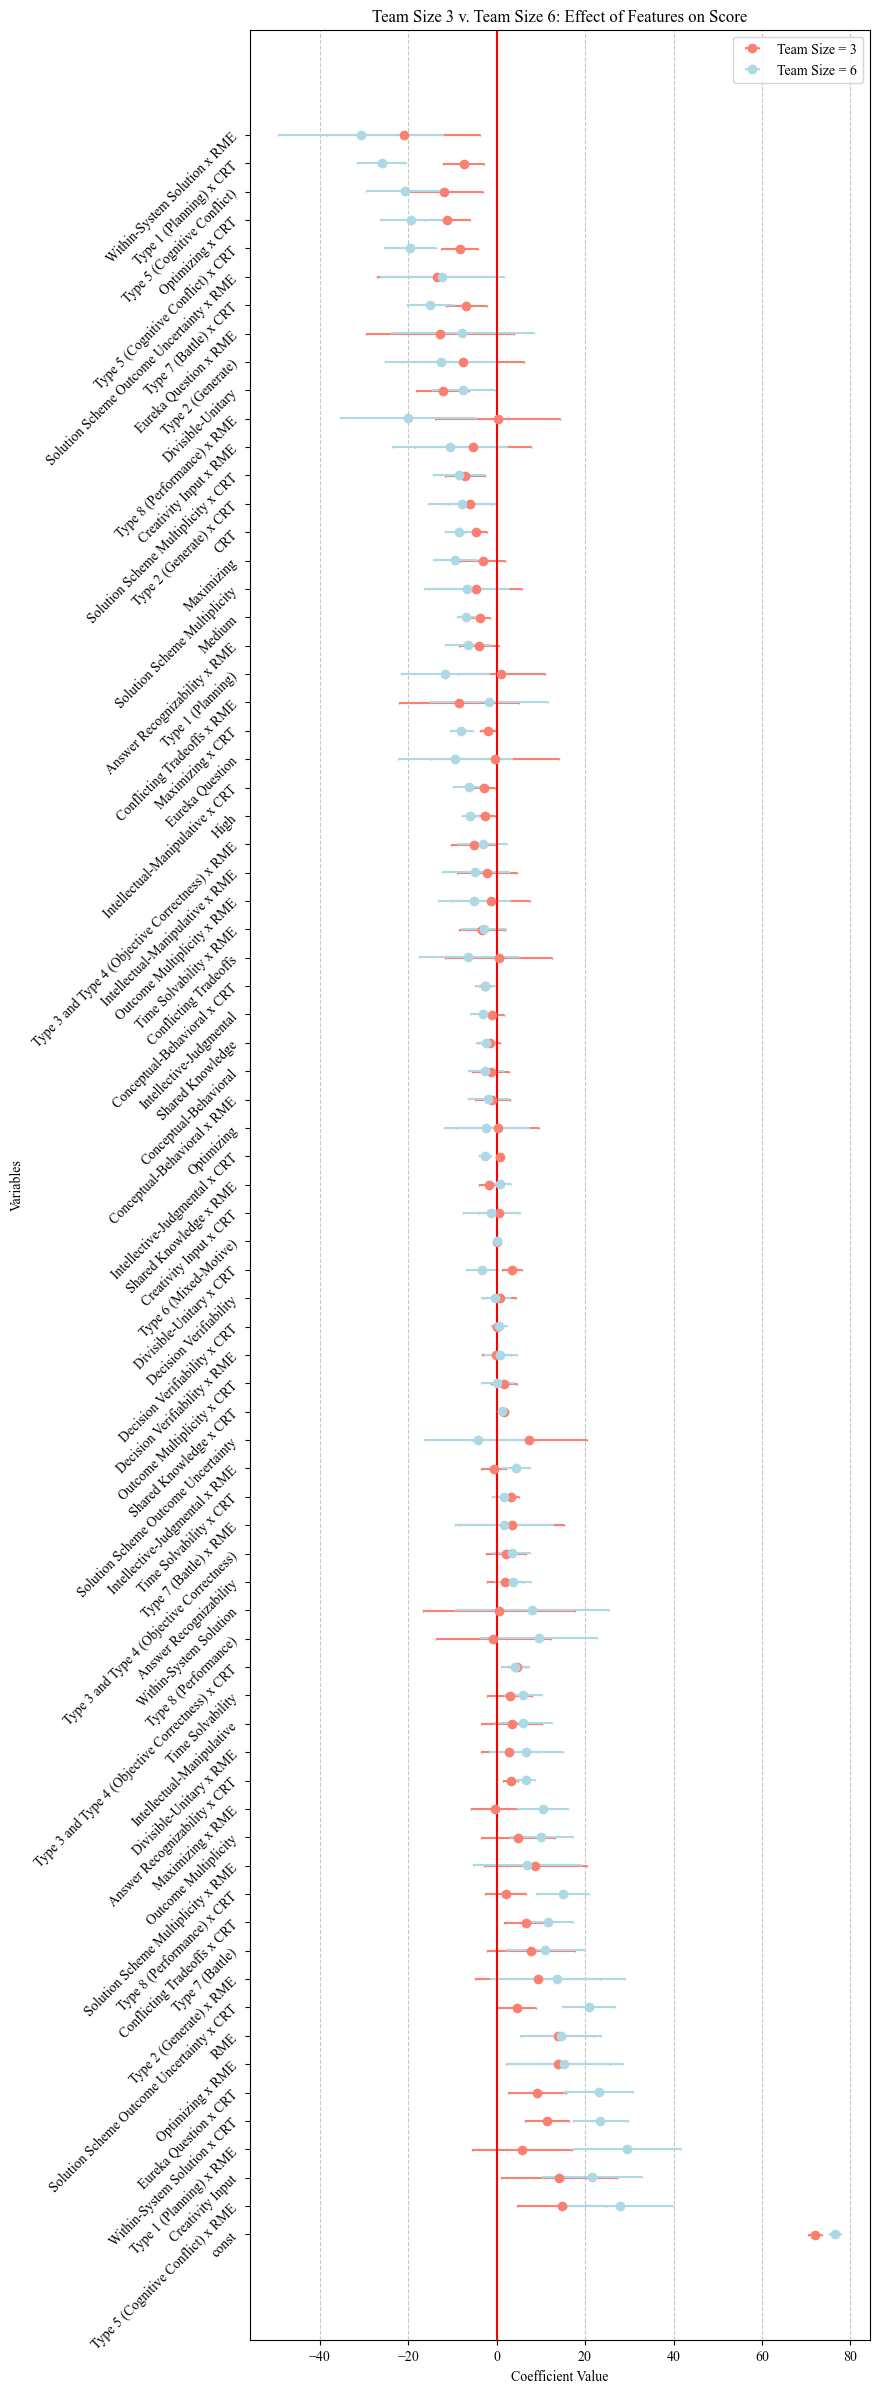

In [49]:
plot_stargazer_for_two_models(models_size, "Team Size = 3", "Team Size = 6", "Team Size 3 v. Team Size 6: Effect of Features on Score")

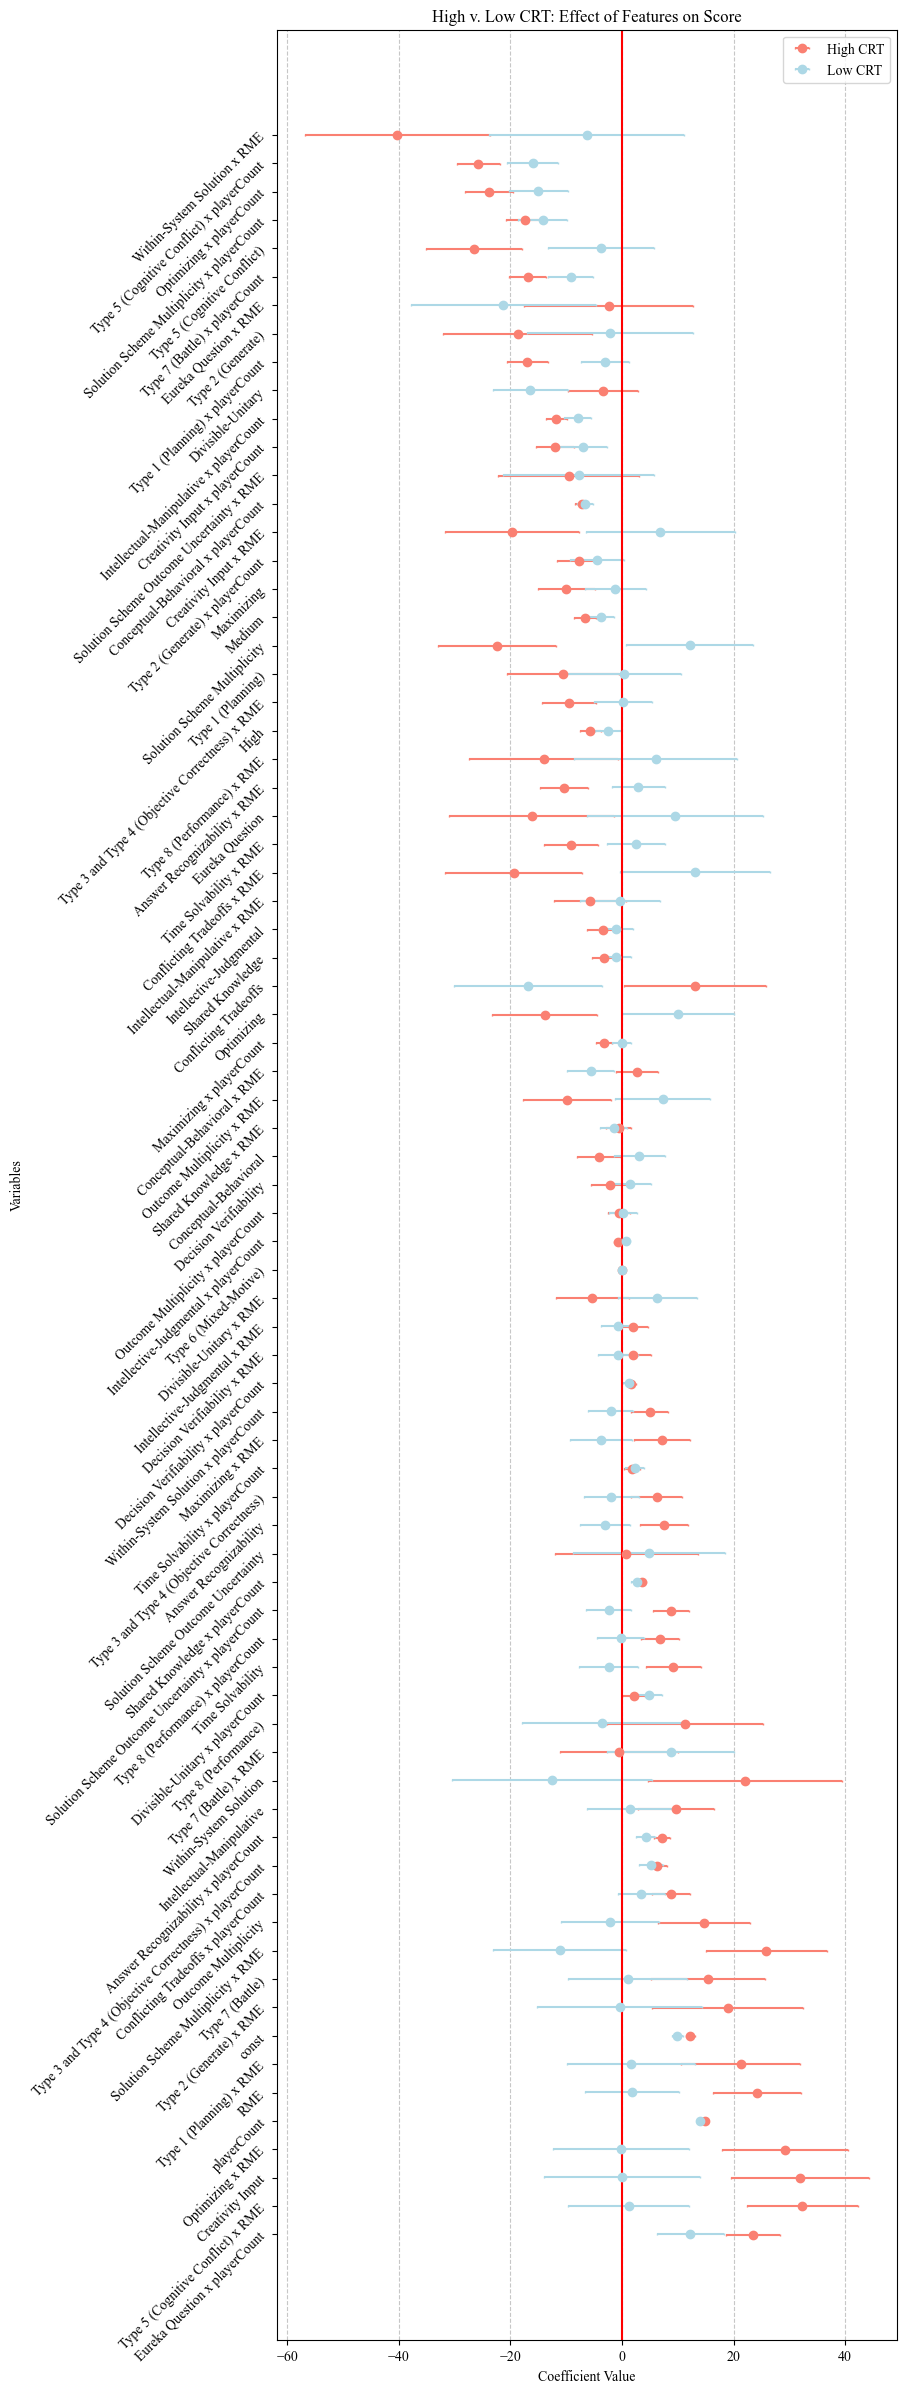

In [50]:
plot_stargazer_for_two_models(models_CRT, "High CRT", "Low CRT", "High v. Low CRT: Effect of Features on Score")

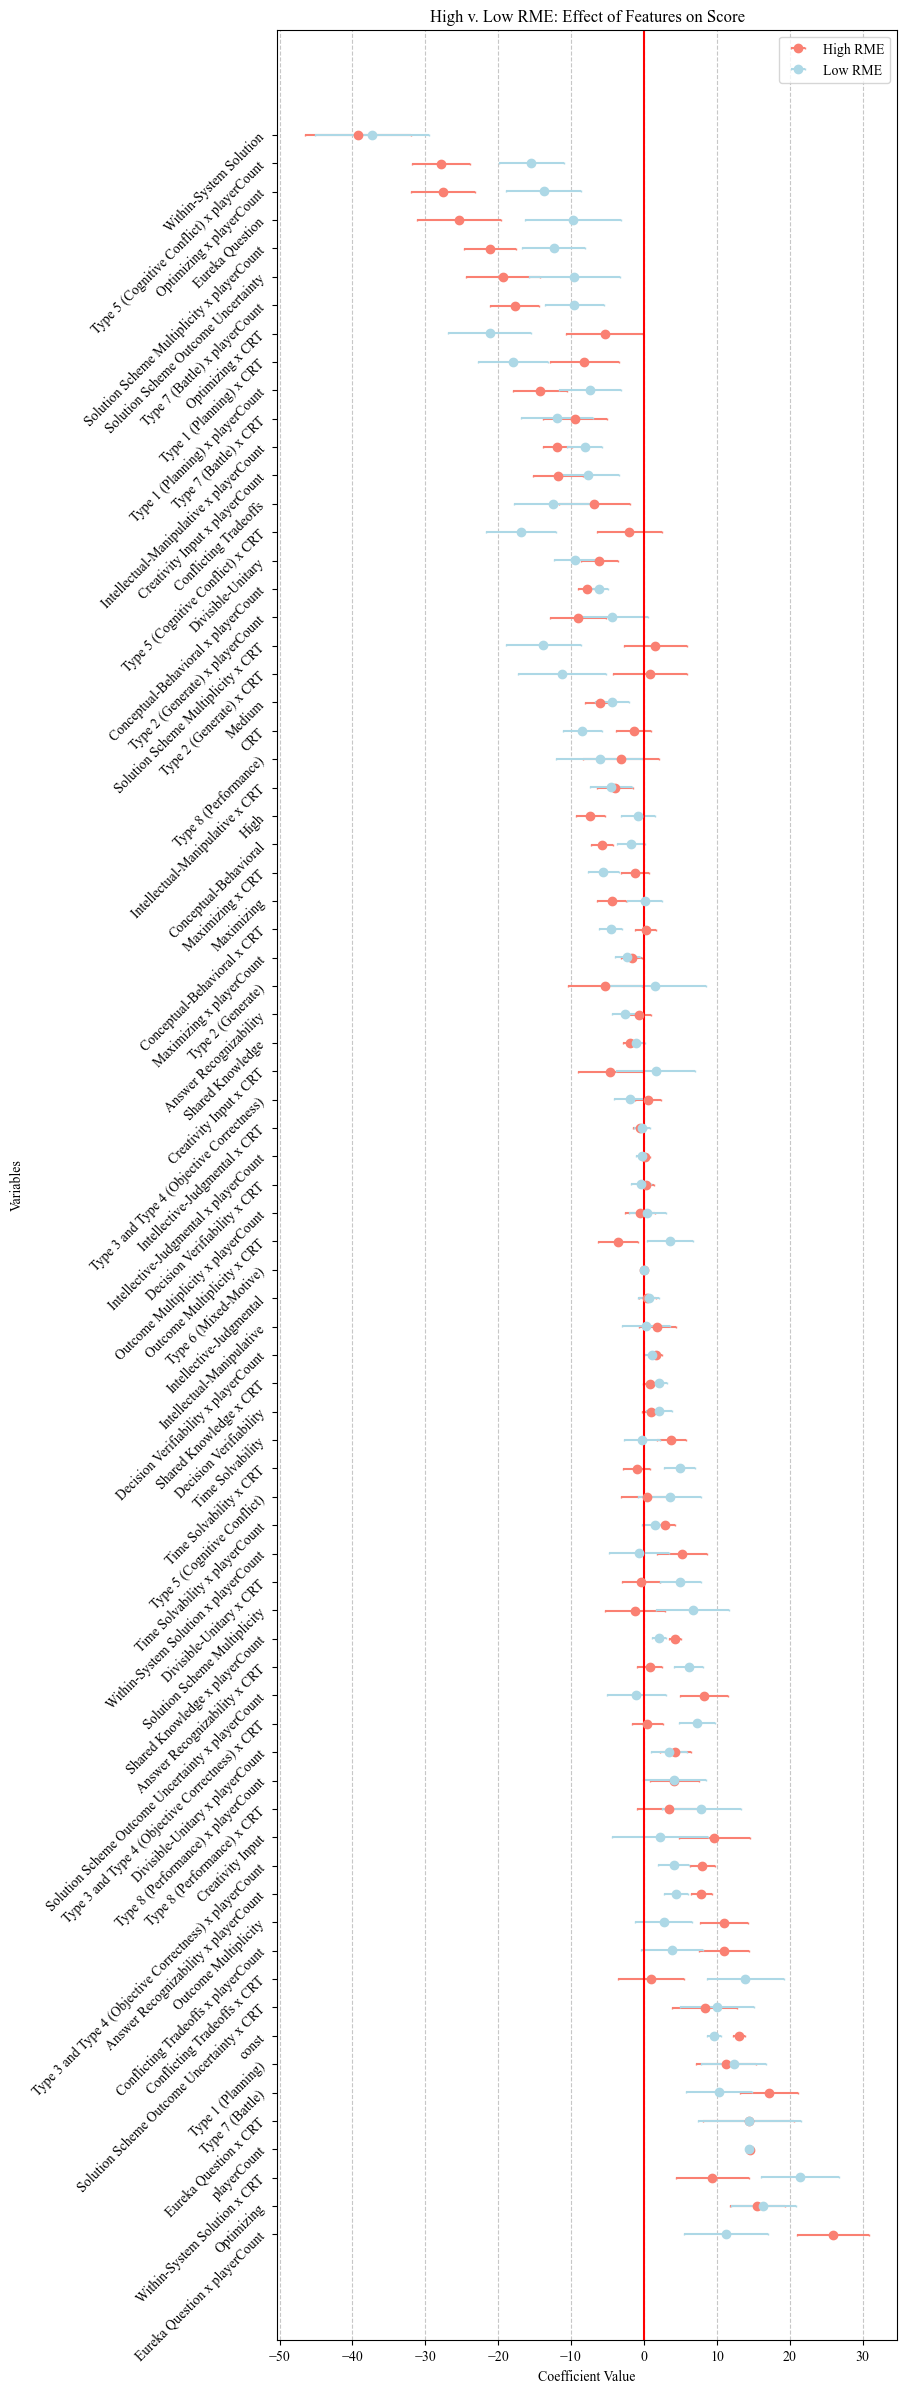

In [51]:
plot_stargazer_for_two_models(models_RME, "High RME", "Low RME", "High v. Low RME: Effect of Features on Score")

## Recreation of PCA Plot (Figure 4) with Real Data

In [28]:
numeric_columns = [col for col in team_multi_task_data.columns if (team_multi_task_data[col].dtype == "int64" or team_multi_task_data[col].dtype == "float64")]

In [29]:
grouped_avg_all_tasks = team_multi_task_data.groupby("task_name")[numeric_columns].agg("mean").reset_index()

In [30]:
pca = PCA(n_components=2)
pca_for_multitask_data = pca.fit_transform(grouped_avg_all_tasks[task_cols_to_use])
pca_df = pd.DataFrame(data=pca_for_multitask_data, columns=["PC1", "PC2"])

# add dvs
pca_df["score"] = grouped_avg_all_tasks["score"]
pca_df["duration"] = grouped_avg_all_tasks["duration"]
pca_df["efficiency"] = grouped_avg_all_tasks["efficiency"]

# concatenate task names so that they can be included as labels
pca_df = pd.concat([pca_df, grouped_avg_all_tasks["task_name"]], axis=1)

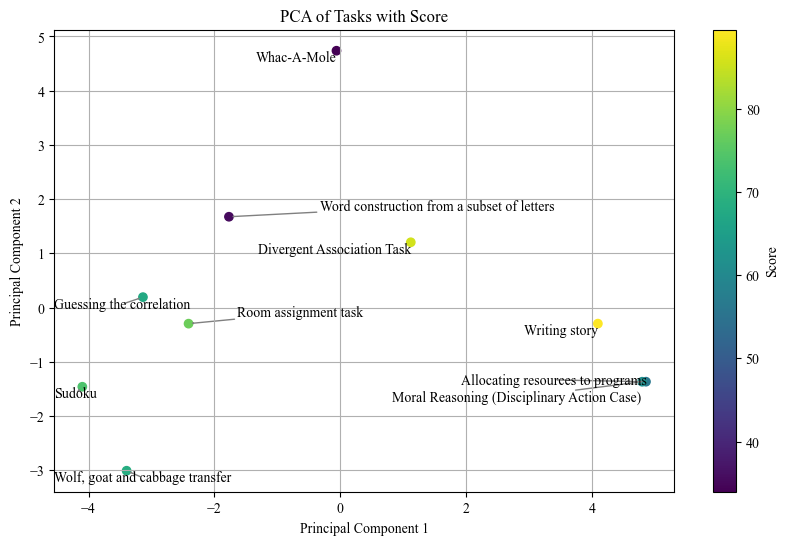

In [31]:
def plot_pca_scatter_with_labels(pca_df, dv, dv_label):
    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(pca_df["PC1"], pca_df["PC2"], c=pca_df[dv])

    plt.title("PCA of Tasks with " + dv_label)
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")

    cbar = plt.colorbar(scatter, label=dv_label)

    texts = []
    for i, txt in enumerate(pca_df["task_name"]):
        texts.append(plt.text(pca_df["PC1"].iloc[i], pca_df["PC2"].iloc[i], txt, ha='left'))

    # adjust text labels to avoid overlap
    adjust_text(texts, arrowprops=dict(arrowstyle='->', color='gray'))

    plt.grid(True)

    plt.show()

plot_pca_scatter_with_labels(pca_df, dv = "score", dv_label="Score")

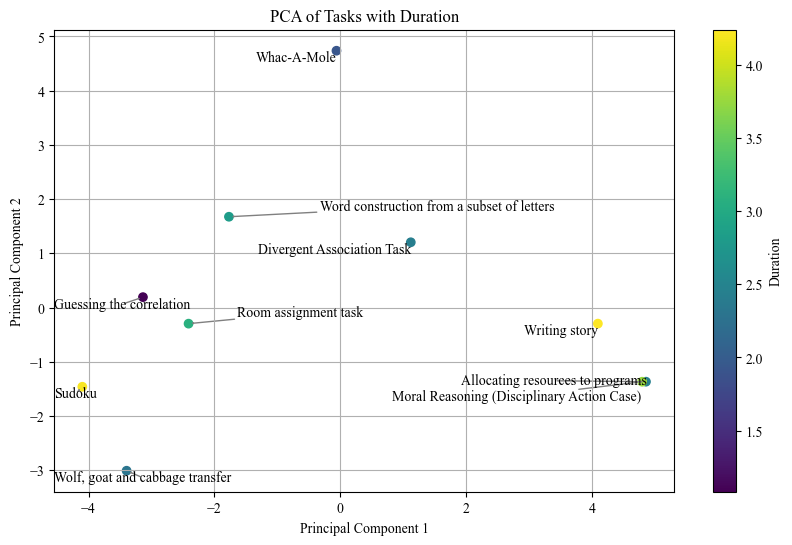

In [32]:
plot_pca_scatter_with_labels(pca_df, dv = "duration", dv_label="Duration")

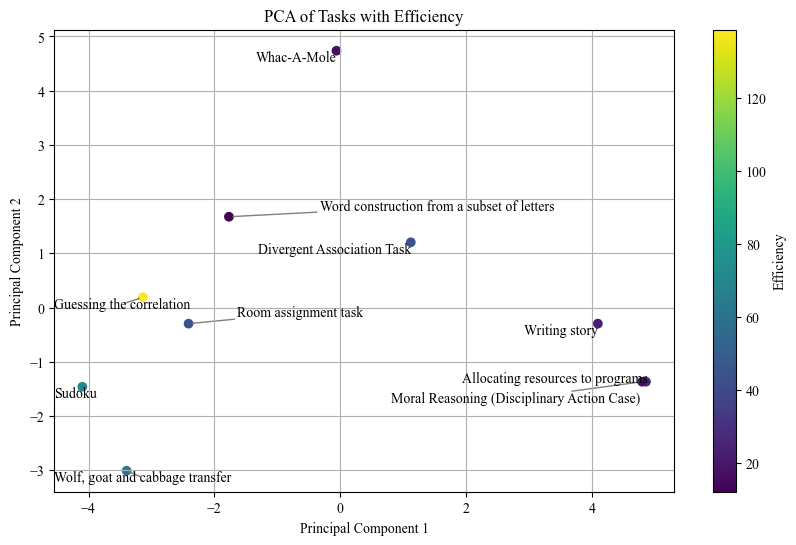

In [33]:
plot_pca_scatter_with_labels(pca_df, dv = "efficiency", dv_label="Efficiency")

# Q^2 Calculation

In [34]:
def reshape_x_y(x, y):
    if(isinstance(x, pd.Series)):
        x = np.asarray(x).reshape(-1, 1)
    else:
        x = np.asarray(x)
    
    y = np.asarray(y).reshape(-1, 1)
    return(x, y)

In [35]:
def q2_task_holdout_helper(x_train, x_test, y_train, y_test, estimator):

    # some reshaping
    x_train_array, y_train_array = reshape_x_y(x_train, y_train)
    x_test_array, y_test_array = reshape_x_y(x_test, y_test)

    # Fit the model and get the error
    fitted_model = estimator.fit(X=x_train_array, y=y_train_array.ravel())
    
    # save prediction error
    prediction = fitted_model.predict(x_test_array)

    # flatten all arrays
    y_test_array = np.asarray(y_test_array).flatten()
    prediction = np.asarray(prediction).flatten()

    # print("y test array", y_test_array)
    # print("prediction", prediction)

    squared_model_prediction_error = (y_test_array - prediction) ** 2

    # save total error for this fold
    squared_average_prediction_error = (y_test_array - np.mean(y_train_array)) ** 2

    return squared_model_prediction_error, squared_average_prediction_error

In [36]:
"""
This is the version of q^2 that holds out EVERYTHING associated with a given task

It trains on all task instances from the "seen" classes, and it tests on task instances of held-out (unseen) classes.

NOTE: this version of the function assumes that x and y are passed in with a column called "task_name"
"""

def get_q2(y, x, estimator = LinearRegression(), num_task_holdouts = 1, N_TASK_SAMPLES = 10):
    squared_model_prediction_errors = []
    squared_average_prediction_errors = []

    num_total_tasks = x["task_name"].nunique()

    # randomly hold out `num_task_holdouts`
    all_possible_task_combos = list(itertools.combinations((x["task_name"].unique()), num_total_tasks - num_task_holdouts))
    
    for sample in all_possible_task_combos:

        x_train_tasks = x[x["task_name"].isin(sample)].drop("task_name", axis = 1)
        x_test_tasks = x[~x["task_name"].isin(sample)].drop("task_name", axis = 1)

        y_train_tasks = y[y["task_name"].isin(sample)].drop("task_name", axis = 1)
        y_test_tasks = y[~y["task_name"].isin(sample)].drop("task_name", axis = 1)

        # get evaluation score by training on the training tasks and evaluating on the holdout tasks
        squared_model_prediction_error, squared_average_prediction_error = q2_task_holdout_helper(x_train_tasks, x_test_tasks, y_train_tasks, y_test_tasks, estimator)
        
        squared_model_prediction_errors.append(squared_model_prediction_error)
        squared_average_prediction_errors.append(squared_average_prediction_error)

    # Print the evaluation score
    squared_model_prediction_error = np.asarray(squared_model_prediction_error).flatten()
    squared_average_prediction_error = np.asarray(squared_average_prediction_error).flatten()
    return 1 - (np.sum(squared_model_prediction_error) / np.sum(squared_average_prediction_error))


In [37]:
# set up prediction
y_score = full_data_standardized[["score", "task_name"]]
y_duration = full_data_standardized[["duration", "task_name"]]
y_efficiency = full_data_standardized[["efficiency", "task_name"]]

x_tasks = full_data_standardized[list(reg_coefficients) + ["task_name"]]

# Other options to play around with
# get_q2(y_score, x_tasks, estimator = xgb.XGBRegressor())
# get_q2(y_score, x_tasks, estimator = Lasso(alpha = best_alpha))

In [38]:
# get_q2(y_score, x_tasks, estimator = MLPRegressor(
#     activation = "relu",
#     hidden_layer_sizes = (128, 256, 128),
#     learning_rate = "adaptive",
#     max_iter = 1000
# ))

In [39]:
# get_q2(y_score, x_tasks, estimator = MLPRegressor(
#     activation = "relu",
#     hidden_layer_sizes = (128, 256, 128),
#     learning_rate = "adaptive",
#     solver = "sgd",
#     max_iter = 1000
# ))

## Train on 9 tasks, Test on 1 task: Predicting DV's Based on Task Attributes

Starting with a vanilla version with no hyperparameter optimization

In [40]:
get_q2(y_score, x_tasks, estimator = RandomForestRegressor())

0.3027675673128162

In [41]:
get_q2(y_duration, x_tasks, estimator = RandomForestRegressor())

-0.18580643602381408

In [42]:
get_q2(y_efficiency, x_tasks, estimator = RandomForestRegressor())

0.8032642915402519

In [43]:
# plot a histogram of an array
def plot_q2_hist(q2_arr):
    plt.hist(q2_arr, bins=10, edgecolor='black')
    plt.axvline(np.mean(q2_arr), color='red', linestyle='dashed', linewidth=2)
    plt.xlabel('Q^2')
    plt.ylabel('Frequency')
    plt.show()

## Adding hyperparameter optimization

In [44]:
# code adapted from Mohammed's q2 optimization notebook
model_dict = {"RandomForestRegressor":{"model":RandomForestRegressor,
					"params":[{"name":"n_estimators", "type":"range", "bounds":[2,200]},
							{"name":"max_depth", "type":"range", "bounds":[1,5]},
							{"name":"min_samples_leaf", "type":"range", "bounds":[1,5]}]},
            #     "MLPRegressor":{"model": MLPRegressor,
			# 		"params":[{"name":"activation", "type":"choice", "values":["identity", "logistic", "tanh", "relu"]},
			# 				{"name":"solver", "type":"choice", "values":["sgd", "adam"]},
            #                 {"name": "alpha", "type": "range", "bounds":[0.0001,1.0]},
            #                 {"name":"learning_rate", "type":"choice", "values":["constant", "adaptive"]},
            #                 {"name":"learning_rate_init", "type":"range", "bounds":[0.0001, 0.01]},
            #                 {"name":"max_iter", "type":"range", "bounds":[350, 650]}
            #             ]},
			   "ElasticNet":{ "model": ElasticNet,
					"params":[{"name": "alpha", "type": "range", "bounds":[0.001,1.0]},
							{"name": "l1_ratio", "type": "range", "bounds":[0.0,1.0]},
							{"name": "max_iter", "type": "range", "bounds":[200, 2000]},
							{"name": "selection", "type": "choice", "values":["cyclic", "random"]}
						]}
			}

def get_optimal_model(y, X, model_type, total_trials):
    best_parameters, best_values, experiment, model = optimize(
        parameters= model_dict[model_type]["params"],
        evaluation_function=lambda p: get_q2(y, X, model_dict[model_type]["model"](**p)),
        minimize=False,
        total_trials=total_trials,
    )
    optimal_parameters = best_parameters 
    optimization_q2 = best_values[0]["objective"]

    return(optimal_parameters, optimization_q2)

In [45]:
optimal_dict = {
    "dv": [],
    "optimal_q2": [],
    "optimal_params": [],
    "model_type": []
}

In [46]:
dvs = ["score", "duration", "efficiency"]

for model_type in model_dict.keys():
    for dv in dvs:
        # set up x and y
        y_dv = full_data_standardized[[dv, "task_name"]]
        x_tasks = full_data_standardized[list(reg_coefficients) + ["task_name"]]

        optimal_params, optimal_q2 = get_optimal_model(y_dv, x_tasks, model_type = model_type, total_trials = 50)
        optimal_dict["dv"].append(dv)
        optimal_dict["optimal_q2"].append(optimal_q2)
        optimal_dict["optimal_params"].append(optimal_params)
        optimal_dict["model_type"].append(model_type)

[INFO 05-03 11:05:34] ax.service.utils.instantiation: Inferred value type of ParameterType.INT for parameter n_estimators. If that is not the expected value type, you can explicitly specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 05-03 11:05:34] ax.service.utils.instantiation: Inferred value type of ParameterType.INT for parameter max_depth. If that is not the expected value type, you can explicitly specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 05-03 11:05:34] ax.service.utils.instantiation: Inferred value type of ParameterType.INT for parameter min_samples_leaf. If that is not the expected value type, you can explicitly specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 05-03 11:05:34] ax.service.utils.instantiation: Created search space: SearchSpace(parameters=[RangeParameter(name='n_estimators', parameter_type=INT, range=[2, 200]), RangeParameter(name='max_depth', parameter_type=INT, range

In [47]:
# save the optimal_dict in the future
with open('./task_map_explorations_with_multitask/optimal_dict_task_class_with_full_multi_task_data_50_trials.pkl', 'wb') as pkl_file:
    pickle.dump(optimal_dict, pkl_file)

In [48]:
# read dict from pkl so that we don't have to run the Ax again
# with open('./task_map_explorations_with_multitask/optimal_dict_task_class_with_full_multi_task_data_50_trials.pkl', 'rb') as pkl_file:
#     optimal_dict = pickle.load(pkl_file)

In [51]:
pd.DataFrame(optimal_dict)

,dv,optimal_q2,optimal_params,model_type
0,score,0.329305,"{'n_estimators': 113, 'max_depth': 1, 'min_sam...",RandomForestRegressor
1,duration,0.010800,"{'n_estimators': 2, 'max_depth': 3, 'min_sampl...",RandomForestRegressor
2,efficiency,0.806815,"{'n_estimators': 157, 'max_depth': 5, 'min_sam...",RandomForestRegressor
3,score,0.456174,"{'alpha': 0.001, 'l1_ratio': 1.0, 'max_iter': ...",ElasticNet
4,duration,0.032776,"{'alpha': 0.46496126015846106, 'l1_ratio': 1.0...",ElasticNet
5,efficiency,0.547920,"{'alpha': 1.0, 'l1_ratio': 0.0, 'max_iter': 10...",ElasticNet


In [67]:
best_params = pd.DataFrame(optimal_dict)
# filter by the Random Forest Regressor
best_params = best_params[best_params["model_type"]=="RandomForestRegressor"]
best_params

,dv,optimal_q2,optimal_params,model_type
0,score,0.329305,"{'n_estimators': 113, 'max_depth': 1, 'min_sam...",RandomForestRegressor
1,duration,0.010800,"{'n_estimators': 2, 'max_depth': 3, 'min_sampl...",RandomForestRegressor
2,efficiency,0.806815,"{'n_estimators': 157, 'max_depth': 5, 'min_sam...",RandomForestRegressor


In [68]:
# do we do any better after optimization?
estimator = RandomForestRegressor(
        n_estimators = dict(best_params)["optimal_params"][list(best_params["dv"]).index("score")]["n_estimators"],
        max_depth = dict(best_params)["optimal_params"][list(best_params["dv"]).index("score")]["max_depth"],
        min_samples_leaf = dict(best_params)["optimal_params"][list(best_params["dv"]).index("score")]["min_samples_leaf"]
    )
get_q2(y_score, x_tasks, estimator = estimator)

0.17739330998126357

In [69]:
estimator = RandomForestRegressor(
        n_estimators = dict(best_params)["optimal_params"][list(best_params["dv"]).index("efficiency")]["n_estimators"],
        max_depth = dict(best_params)["optimal_params"][list(best_params["dv"]).index("efficiency")]["max_depth"],
        min_samples_leaf = dict(best_params)["optimal_params"][list(best_params["dv"]).index("efficiency")]["min_samples_leaf"]
    )
get_q2(y_efficiency, x_tasks, estimator = estimator)

-1.8017149073639533

In [71]:
estimator = RandomForestRegressor(
        n_estimators = dict(best_params)["optimal_params"][list(best_params["dv"]).index("duration")]["n_estimators"],
        max_depth = dict(best_params)["optimal_params"][list(best_params["dv"]).index("duration")]["max_depth"],
        min_samples_leaf = dict(best_params)["optimal_params"][list(best_params["dv"]).index("duration")]["min_samples_leaf"]
    )
get_q2(y_duration, x_tasks, estimator = estimator)

0.651641549683702

## Q^2 by Number of Features

In [76]:
# q^2 for univariate features
q_2_for_all_dvs_task = []
dvs = ["score", "duration", "efficiency"]    
for dv in dvs:
    within_dv_arr = []
    for col in task_cols_to_use: #list(nonzero_lasso_weights): # task_cols_to_use: # Design decision --- we're again just focusing on the columns selected by LASSO
        # get the q2 for each
        y_dv = full_data_standardized[[dv, "task_name"]]
        x_tasks = full_data_standardized[[col] + ["task_name"]]
        q2 = get_q2(y_dv, x_tasks)

        within_dv_arr.append(q2)

    q_2_for_all_dvs_task.append(within_dv_arr)

In [78]:
# turn this into a dataframe
q2_by_dv_df_task = pd.DataFrame(q_2_for_all_dvs_task, columns=task_cols_to_use, index = dvs)
# sort by average
q2_by_dv_df_task = q2_by_dv_df_task.reindex(q2_by_dv_df_task.mean().sort_values(ascending=False).index, axis=1)

In [79]:
q2_by_dv_df_task

,Creativity Input,Solution Scheme Multiplicity,Shared Knowledge,Intellective-Judgmental,Type 7 (Battle),Time Solvability,Type 3 and Type 4 (Objective Correctness),Decision Verifiability,Within-System Solution,Answer Recognizability,...,Outcome Multiplicity,Maximizing,Intellectual-Manipulative,Divisible-Unitary,Solution Scheme Outcome Uncertainty,Conceptual-Behavioral,Type 8 (Performance),Type 1 (Planning),Optimizing,Conflicting Tradeoffs
score,0.390480,-0.027239,-0.032893,-0.107569,0.088270,-0.242924,-0.271821,-0.415739,-0.196881,-0.384989,...,-0.553877,0.402005,0.051838,0.027055,-0.020815,0.189209,-0.197330,-0.124595,-0.905536,-0.075472
duration,0.165129,0.267995,0.199205,0.208416,0.186695,0.062834,0.102772,0.085670,-0.123726,-0.034080,...,0.003805,0.255452,0.020035,-0.004188,0.154881,0.077449,-0.231772,-0.014972,0.001265,-0.168758
efficiency,0.817667,0.706850,0.777177,0.712220,0.394809,0.821385,0.787354,0.797585,0.742325,0.823583,...,0.646582,-0.666456,-0.089576,-0.057523,-0.200400,-0.339361,0.294463,-0.045967,0.547330,-0.789763


In [55]:
# get top univariate features
def top_n_q2_for_index(index, n):
    q2_by_dv_df = q2_by_dv_df_task
    top_columns = q2_by_dv_df.loc[index].nlargest(n).index.tolist()
    return top_columns

In [56]:
def get_q2_improvement_with_number_of_tasks(estimator, feature_list, dvs = ["score", "duration", "efficiency"], optimize_each_step = False, model_type = None):   
    dv_output_dict_best = {}

    for i, dv in enumerate(dvs):
        dv_output_dict_best[dv] = []

        for num_features in range(1, len(feature_list)+1):
            print("Now running models for " + str(num_features) + " features...")
            
            # select the best model by choosing the top features in terms of univariate q^2
            top_features_class = top_n_q2_for_index(dv, num_features)
            y_dv = full_data_standardized[[dv, "task_name"]]
            x_tasks = full_data_standardized[list(top_features_class) + ["High", "Medium", "playerCount", "task_name"]] # also control for the playerCount and complexity in the model

            if(optimize_each_step): # optimize a model with hyperparameters for THIS set of features
                optimal_params, optimal_q2 = get_optimal_model(y_dv, x_tasks, model_type = model_type, total_trials = 10)
                print("Found optimal model with Q^2 of " + str(optimal_q2))
                estimator = model_dict[model_type]["model"](**optimal_params)
            
            q2_class = get_q2(y_dv, x_tasks, estimator=estimator) 
            dv_output_dict_best[dv].append(q2_class)
    
    return dv_output_dict_best

In [73]:
pd.DataFrame(optimal_dict)

,dv,optimal_q2,optimal_params,model_type
0,score,0.329305,"{'n_estimators': 113, 'max_depth': 1, 'min_sam...",RandomForestRegressor
1,duration,0.010800,"{'n_estimators': 2, 'max_depth': 3, 'min_sampl...",RandomForestRegressor
2,efficiency,0.806815,"{'n_estimators': 157, 'max_depth': 5, 'min_sam...",RandomForestRegressor
3,score,0.456174,"{'alpha': 0.001, 'l1_ratio': 1.0, 'max_iter': ...",ElasticNet
4,duration,0.032776,"{'alpha': 0.46496126015846106, 'l1_ratio': 1.0...",ElasticNet
5,efficiency,0.547920,"{'alpha': 1.0, 'l1_ratio': 0.0, 'max_iter': 10...",ElasticNet


In [84]:
# MLPRegressor
# best_estimator = MLPRegressor(
#     alpha = optimal_dict["optimal_params"][i]["alpha"],
#     learning_rate_init = optimal_dict["optimal_params"][i]["learning_rate_init"],
#     max_iter = optimal_dict["optimal_params"][i]["max_iter"],
#     activation = optimal_dict["optimal_params"][i]["activation"],
#     solver = optimal_dict["optimal_params"][i]["solver"],
#     learning_rate = optimal_dict["optimal_params"][i]["learning_rate"]
# )

for dv in ["score"]:#, "duration", "efficiency"]:

    best_estimator = RandomForestRegressor(
        n_estimators = optimal_dict["optimal_params"][list(best_params["dv"]).index(dv)]["n_estimators"],
        max_depth = optimal_dict["optimal_params"][list(best_params["dv"]).index(dv)]["max_depth"],
        min_samples_leaf = optimal_dict["optimal_params"][list(best_params["dv"]).index(dv)]["min_samples_leaf"]
    )

    dv_output_dict_best = get_q2_improvement_with_number_of_tasks(estimator = best_estimator, feature_list = list(nonzero_lasso_weights))

Now running models for 1 features...
Now running models for 2 features...
Now running models for 3 features...
Now running models for 4 features...
Now running models for 5 features...
Now running models for 6 features...
Now running models for 7 features...
Now running models for 8 features...
Now running models for 9 features...
Now running models for 1 features...
Now running models for 2 features...
Now running models for 3 features...
Now running models for 4 features...
Now running models for 5 features...
Now running models for 6 features...
Now running models for 7 features...
Now running models for 8 features...
Now running models for 9 features...
Now running models for 1 features...
Now running models for 2 features...
Now running models for 3 features...
Now running models for 4 features...
Now running models for 5 features...
Now running models for 6 features...
Now running models for 7 features...
Now running models for 8 features...
Now running models for 9 features...


In [85]:
pd.DataFrame(dv_output_dict_best)

,score,duration,efficiency
0,0.353145,0.153095,0.806971
1,0.356182,0.341389,0.793109
2,0.350528,0.279745,0.804122
3,0.351157,0.322067,0.812838
4,0.353256,0.269983,0.812914
5,0.349435,0.257654,0.777438
6,0.350295,0.254537,0.780796
7,0.351073,0.258546,0.783782
8,0.352221,0.257674,0.686608


### Line Plot as Number of Features Increases

In [86]:
def plot_q2_by_number_of_features(df_q2_means_for_feature, feature_list, title):
    fig, ax = plt.subplots(layout='constrained', figsize=(24, 5))

    # Store colors for each DV
    dv_colors = {}

    width = 0.16  # the width of the bars
    multiplier = 0

    for dv in df_q2_means_for_feature.columns:
        means_for_key = df_q2_means_for_feature[dv]
        # stds_for_key = df_q2_stds_for_feature[dv]
        # offset = width * multiplier
        # offset_back = (0.16) * 2.5
        # line plot version
        line, = ax.plot(np.arange(1, len(feature_list)+1), means_for_key, label=f'{dv}')
        dv_colors[dv] = line.get_color()  # Store the color for this DV

        # bar plot version
        # rects = ax.bar(np.arange(1, len(feature_list)+1) + offset - offset_back, means_for_key, width, label=f'{dv}')
        for i in range(1, len(feature_list)+1):
            x = i # + offset - offset_back
            y = means_for_key[i-1]
            # std = stds_for_key[i-1]
            # ax.errorbar(x, y, std, color="black")
        multiplier += 1

    # Adding horizontal gray line at y=0
    ax.axhline(0, color='gray', linestyle='--', linewidth=1.5)

    # Add horizontal lines for "optimal" model performance for each DV
    # TODO --- this needs to be adjusted based on the optimality of task class LOO versus task instance LOO
    # for dv in df_q2_means_for_feature.columns:
    #     optimal_df = pd.DataFrame(optimal_dict)
    #     performance_for_dv = optimal_df[optimal_df["dv"] == dv]
    #     best_perf = np.max(performance_for_dv["optimal_q2"])
    #     ax.axhline(best_perf, color=dv_colors[dv], linestyle='--', linewidth=1.5)

    # ax.set_ylim(-4, 4)
    ax.legend(fontsize=14, loc='lower right')
    plt.xticks(ticks=[_ for _ in range(1, len(feature_list)+1)], fontsize=24)
    plt.yticks(fontsize=24)

    plt.xlabel('Number of Task Features Included', fontsize=24)
    plt.ylabel('Q^2', fontsize=24)

    plt.title(title, fontsize = 24)

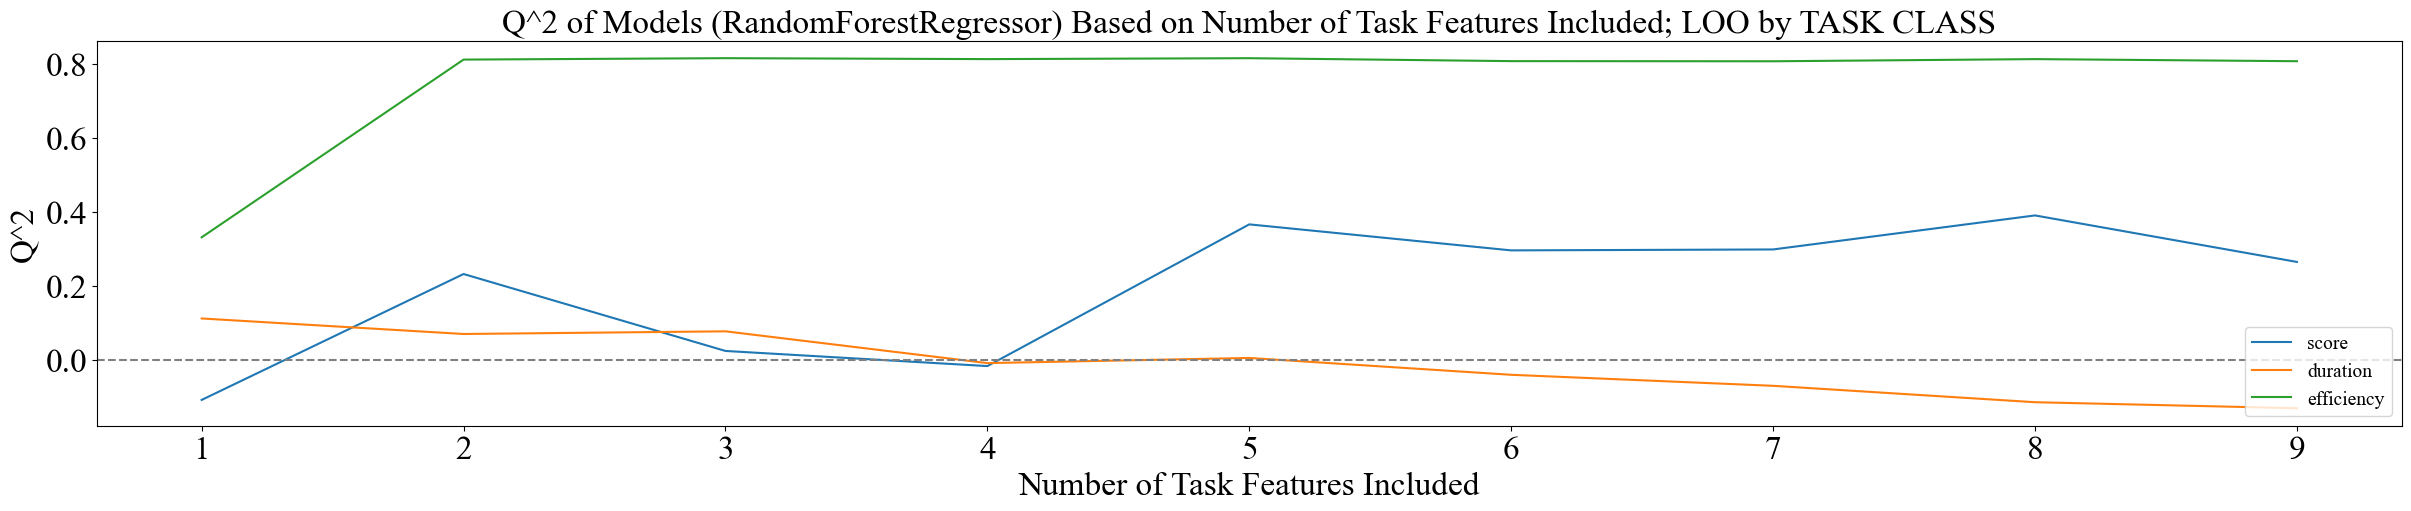

In [60]:
df_q2_means_for_feature = pd.DataFrame()
for key in dv_output_dict_best.keys():
    means = [np.mean(sublist) for sublist in dv_output_dict_best[key]]
    df_q2_means_for_feature[key] = means

plot_q2_by_number_of_features(df_q2_means_for_feature, feature_list = list(nonzero_lasso_weights), title = 'Q^2 of Models (RandomForestRegressor) Based on Number of Task Features Included; LOO by TASK CLASS')

# [Backlog] Q^2 at the Instance Level

In [61]:
# This does q2 at the *task instance level*
def q2_baseline_models(y, X, estimator):
    baseline_models = []
    for loo_index in range(len(y)):
        if hasattr(estimator, "random_state"):
            estimator.random_state = loo_index

        x_train, y_train = reshape_x_y(X.drop(loo_index), y.drop(loo_index))
        baseline_models.append(deepcopy(estimator.fit(X=x_train, y=y_train.ravel())))
        
    return baseline_models

def get_q2_task_instance(y, X, estimator=LinearRegression()):
    models = q2_baseline_models(y, X, estimator)
    q2_means = []
    q2_preds = []
    
    for loo_index in range(len(y)):
        q2_means.append(y.drop(loo_index).mean())
        q2_preds.append(models[loo_index].predict(np.array(X.iloc[loo_index]).reshape(1,-1)))

    # fix dimensions
    q2_means = np.array(q2_means)
    q2_preds = np.array(q2_preds).flatten()

    q2 = 1 - np.sum((q2_preds - np.array(y).flatten())**2) / np.sum((q2_means - np.array(y).flatten())**2)
    
    return q2